In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [2]:
# Establishing connection
conn = sqlite3.connect('cleaned_credit_fraud_data.db')
# Creating a cursor object
cursor = conn.cursor()

In [3]:
# Querying the data
cursor.execute('SELECT * FROM fraudTrain')
data = cursor.fetchall()

columns = [i[0] for i in cursor.description]
# Extracting the data into pandas dataframe
df = pd.DataFrame(data, columns = columns)

#Closing connection
conn.close()

In [4]:
df.drop(['lat', 'long', 'merch_lat', 'merch_long', 'field1', 'cc_num', 'full_name'], 
        axis = 1, inplace = True)

In [5]:
dt = 'trans_date_trans_time'
numeric = ['amt', 'city_pop', 'distance', 'age']
cat = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job', 'full_name']

In [6]:
df.drop('trans_date_trans_time', axis = 1, inplace = True)

In [7]:
from category_encoders import HashingEncoder, OneHotEncoder

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('is_fraud', axis= 1)
y = df['is_fraud']
X['zip'] = X['zip'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify = y)

y_train.to_csv('training_label.csv')
y_test.to_csv('testing_label.csv')

In [9]:
del df

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

<ipython-input-10-59fae8724737>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric] = scaler.transform(X_train[numeric])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-10-59fae8724737>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [11]:
ohe_columns = ['gender', 'category', 'state']

In [12]:
ohe = OneHotEncoder(cols = ohe_columns, return_df=True, use_cat_names=True).fit(X_train.reset_index(drop=True))

X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


'merchants' (693), 'street' (982), 'city' (894), 'zip' (970), 'job' (494)

In [13]:
from sklearn.feature_extraction import FeatureHasher

In [14]:
def feat_hash(column):
    global X_train
    global X_test
    
    fh = FeatureHasher(n_features=50, input_type='string')
    train = fh.fit_transform(X_train[column])
    test = fh.transform(X_test[column])
    col_name = ['{}_{}'.format(column, i) for i in range(50)]
    train_df = pd.DataFrame(train.toarray(), columns=col_name)
    test_df = pd.DataFrame(test.toarray(), columns=col_name)
    return train_df, test_df

In [15]:
merch_tr, merch_te = feat_hash('merchant')

In [16]:
street_tr, street_te = feat_hash('street')

In [17]:
city_tr, city_te = feat_hash('city')

In [18]:
job_tr, job_te = feat_hash('job')

In [19]:
zip_tr, zip_te = feat_hash('zip')

In [20]:
X_train.drop(['merchant', 'street', 'city', 'job', 'zip'], axis = 1, inplace = True)
X_test.drop(['merchant', 'street', 'city', 'job', 'zip'], axis = 1, inplace = True)

In [21]:
X_train_hashing = pd.concat([X_train.reset_index(drop=True), merch_tr, street_tr, city_tr, job_tr, zip_tr], axis = 1)
X_test_hashing = pd.concat([X_test.reset_index(drop=True), merch_te, street_te, city_te, job_te, zip_te], axis = 1)

In [22]:
del X_train
del X_test

In [23]:
#Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report

def metrics(model):
    y_train_pred = model.predict(X_train_hashing.values)
    y_test_pred = model.predict(X_test_hashing.values)
    
    print('Training Accuracy_score = ', accuracy_score(y_train, y_train_pred))
    print('Testing Accurcay_score = ', accuracy_score(y_test, y_test_pred))
    
    print('f1_score = ', f1_score(y_test, y_test_pred))
    
    print(classification_report(y_test, y_test_pred))

In [24]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train_hashing.values, y_train)
metrics(dtc)

Training Accuracy_score =  1.0
Testing Accurcay_score =  0.9961902587847696
f1_score =  0.6829268292682926
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322292
           1       0.66      0.71      0.68      1877

    accuracy                           1.00    324169
   macro avg       0.83      0.85      0.84    324169
weighted avg       1.00      1.00      1.00    324169



In [25]:
y_test_pred = dtc.predict(X_test_hashing.values)

Text(0, 0.5, 'precision')

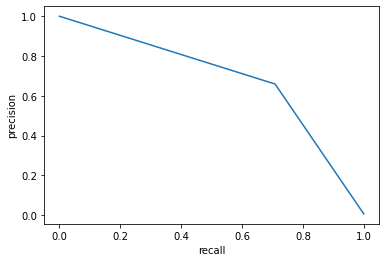

In [26]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision = list()
recall = list()

precision, recall, _ = precision_recall_curve(y_test,y_test_pred)
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")

In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_hashing.values, y_train)
metrics(rfc)

Training Accuracy_score =  0.9999979434574182
Testing Accurcay_score =  0.9958570992291058
f1_score =  0.4604258738449177
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322292
           1       0.94      0.31      0.46      1877

    accuracy                           1.00    324169
   macro avg       0.97      0.65      0.73    324169
weighted avg       1.00      1.00      0.99    324169



In [28]:
y_test_pred = rfc.predict(X_test_hashing.values)

Text(0, 0.5, 'precision')

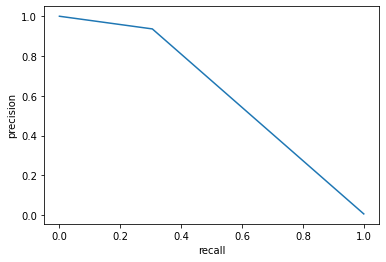

In [29]:
precision= list()
recall= list()

precision, recall, _ = precision_recall_curve(y_test,y_test_pred)
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")

In [30]:
features = X_train_hashing.columns
importance = rfc.feature_importances_

In [31]:
imp = pd.DataFrame({'Features': features, 'Importance' : importance})

In [32]:
imp.sort_values(by='Importance', ascending = False).head(20)

,Features,Importance
14,amt,0.339198
69,distance,0.073453
70,age,0.034087
11,category_grocery_pos,0.027110
102,merchant_31,0.018184
80,merchant_9,0.018051
116,merchant_45,0.016152
115,merchant_44,0.015461
103,merchant_32,0.015020
71,merchant_0,0.014349


In [33]:
no_imp = imp[imp['Importance'] < 0.001].copy()

In [34]:
no_imp['Features'] = no_imp['Features'].str.replace('(_[0-9]*)', '', regex = True)
no_imp['Features'] = no_imp['Features'].str.replace('([A-Z]*)', '', regex = True)

In [35]:
no_imp['Features'].value_counts()

state       50
zip         42
job         31
city        31
street      26
merchant    23
Name: Features, dtype: int64

We will remove ZIP and State

In [36]:
drop_cols_state = [i for i in X_train_hashing.columns if i.startswith('state')]

In [37]:
drop_cols_zip = [i for i in X_train_hashing.columns if i.startswith('zip')]

In [38]:
X_train_hashing.drop(drop_cols_state+drop_cols_zip, axis= 1, inplace = True)

In [39]:
X_test_hashing.drop(drop_cols_state+drop_cols_zip, axis= 1, inplace = True)

In [40]:
from sklearn.ensemble import RandomForestClassifier
rfc_1 = RandomForestClassifier()
rfc_1.fit(X_train_hashing.values, y_train)
metrics(rfc_1)

Training Accuracy_score =  0.9999969151861274
Testing Accurcay_score =  0.9962673790522845
f1_score =  0.5461365341335334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322292
           1       0.92      0.39      0.55      1877

    accuracy                           1.00    324169
   macro avg       0.96      0.69      0.77    324169
weighted avg       1.00      1.00      1.00    324169



In [41]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train_hashing.values, y_train)
metrics(dtc)

Training Accuracy_score =  1.0
Testing Accurcay_score =  0.9961100537065543
f1_score =  0.6759187869442302
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322292
           1       0.65      0.70      0.68      1877

    accuracy                           1.00    324169
   macro avg       0.83      0.85      0.84    324169
weighted avg       1.00      1.00      1.00    324169



The model got better when we removed the two features

In [42]:
features = X_train_hashing.columns
importance = rfc_1.feature_importances_

In [43]:
imp = pd.DataFrame({'Features': features, 'Importance' : importance})

In [44]:
imp.sort_values(by='Importance', ascending = False).head(20)

,Features,Importance
14,amt,0.365254
18,distance,0.069443
19,age,0.034922
11,category_grocery_pos,0.025840
51,merchant_31,0.017416
29,merchant_9,0.016021
17,city_pop,0.014428
65,merchant_45,0.014376
64,merchant_44,0.014068
52,merchant_32,0.013937


In [45]:
no_imp = imp[imp['Importance'] < 0.001].copy()

In [46]:
no_imp['Features'].value_counts()

job_18         1
city_8         1
job_14         1
city_5         1
city_40        1
              ..
city_23        1
city_1         1
merchant_23    1
city_33        1
city_21        1
Name: Features, Length: 109, dtype: int64

In [47]:
no_imp['Features'] = no_imp['Features'].str.replace('(_[0-9]*)', '', regex = True)
no_imp['Features'] = no_imp['Features'].str.replace('([A-Z]*)', '', regex = True)

In [48]:
no_imp['Features'].value_counts()

city        31
job         29
street      26
merchant    23
Name: Features, dtype: int64

We will not remove any further features

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
lr = LogisticRegression(penalty = 'l1', max_iter = 500, solver = 'liblinear')

lr.fit(X_train_hashing.values, y_train)

LogisticRegression(max_iter=500, penalty='l1', solver='liblinear')

In [51]:
metrics(lr)

Training Accuracy_score =  0.9936781881037238
Testing Accurcay_score =  0.9937224102242966
f1_score =  0.0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    322292
           1       0.00      0.00      0.00      1877

    accuracy                           0.99    324169
   macro avg       0.50      0.50      0.50    324169
weighted avg       0.99      0.99      0.99    324169



In [132]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_hashing.values, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [134]:
y_train_pred = xgb.predict(X_train_hashing.values)
y_test_pred = xgb.predict(X_test_hashing.values)
  
print('Training Accuracy_score = ', accuracy_score(y_train, y_train_pred))
print('Testing Accurcay_score = ', accuracy_score(y_test, y_test_pred))
    
print('f1_score = ', f1_score(y_test, y_test_pred))
    
print(classification_report(y_test, y_test_pred))

Training Accuracy_score =  0.9985511657511624
Testing Accurcay_score =  0.997720324892263
f1_score =  0.7879483500717359
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322292
           1       0.85      0.73      0.79      1877

    accuracy                           1.00    324169
   macro avg       0.93      0.87      0.89    324169
weighted avg       1.00      1.00      1.00    324169



Text(0, 0.5, 'precision')

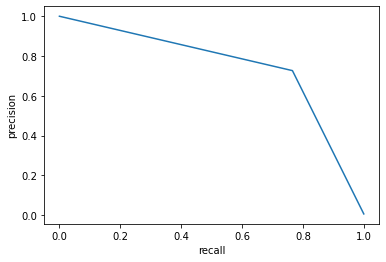

In [135]:
precision = list()
recall = list()

precision, recall, _ = precision_recall_curve(y_test,y_test_pred_)
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")

In [126]:
from eli5 import show_weights

In [141]:
show_weights(xgb, feature_names = X_train_hashing.columns.to_list())

Weight,Feature
0.3824,category_grocery_pos
0.1066,category_gas_transport
0.0350,amt
0.0201,category_entertainment
0.0165,category_grocery_net
0.0145,category_home
0.0141,category_misc_net
0.0137,category_shopping_net
0.0131,category_health_fitness
0.0131,category_kids_pets
